In [36]:
!ls sub43data/

baseline-conn-mat-sub43.png
rs-conn-mat-sub43.png
sub-43_ses-01_task-RLbaseline_run-1_space-fsLR_den-91k_bold_timeseries.tsv
sub-43_ses-01_task-RLlearning_run-1_space-fsLR_den-91k_bold_timeseries.tsv
sub-43_ses-01_task-rest_run-1_space-fsLR_den-91k_bold_timeseries.tsv
sub-43_ses-02_task-leftbaseline_run-1_space-fsLR_den-91k_bold_timeseries.tsv
sub-43_ses-02_task-lefttransfer_run-1_space-fsLR_den-91k_bold_timeseries.tsv
sub-43_ses-02_task-rightbaseline_run-1_space-fsLR_den-91k_bold_timeseries.tsv
sub-43_ses-02_task-rightlearning_run-1_space-fsLR_den-91k_bold_timeseries.tsv


In [11]:
import pandas as pd
baseline = pd.read_csv('sub43data/sub-43_ses-01_task-RLbaseline_run-1_space-fsLR_den-91k_bold_timeseries.tsv', delimiter='\t')
baseline.shape

(219, 998)

In [35]:
baseline

,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,7Networks_LH_Vis_10,...,7Networks_RH_Default_pCunPCC_11,7Networks_RH_Default_pCunPCC_12,7Networks_RH_Default_pCunPCC_13,7Networks_RH_Default_pCunPCC_14,7Networks_RH_Default_pCunPCC_15,7Networks_RH_Default_pCunPCC_16,7Networks_RH_Default_pCunPCC_17,7Networks_RH_Default_pCunPCC_18,7Networks_RH_Cont_pCun_2,7Networks_RH_Cont_pCun_4
0,1.426101,1.894554,0.201228,0.934306,-0.719173,1.862952,1.770194,-1.051675,-0.052146,1.937436,...,-0.105906,0.404949,0.154965,1.315908,2.106569,1.049609,0.880375,1.617281,0.552326,1.012995
1,0.987042,0.709333,-0.333374,-0.174620,-1.405659,1.401849,-0.041699,-1.695795,-0.020028,1.852793,...,-0.969248,-0.280748,-0.217879,0.388161,-0.391417,-0.449851,-0.697848,-0.607093,-0.540475,-0.328749
2,0.898949,-0.280639,-0.555696,-1.077322,-1.804169,0.943675,-1.057008,-2.015780,-0.196367,1.585644,...,-1.470856,-0.817994,-0.417104,-0.370660,-1.790307,-1.377391,-1.449576,-1.671114,-1.169890,-1.043530
3,1.193234,-0.721210,-0.242093,-1.432626,-1.684359,0.669252,-1.110382,-1.650742,-0.534842,1.292074,...,-1.310635,-1.037374,-0.361897,-0.810234,-1.677856,-1.457524,-1.124837,-1.327585,-1.044244,-0.948039
4,1.578545,-0.315702,0.554474,-1.034153,-1.059829,0.761852,-0.633313,-0.569117,-0.821442,1.213028,...,-0.501737,-0.820150,-0.084855,-0.860794,-0.494103,-0.859157,-0.224065,-0.321957,-0.248317,-0.358914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,-0.056728,-1.299437,-0.492261,-1.353995,-0.668154,-0.326271,-1.496279,-0.350578,-1.011852,-0.140495,...,-0.363986,-1.520063,-2.288574,-1.654971,-1.052532,-2.203994,-2.549042,-2.576638,-1.866505,-2.310875
215,0.425614,-1.421723,-0.879061,-1.400200,-0.597759,-0.424635,-1.899306,0.041662,-1.599040,-0.652906,...,-0.644511,-1.388642,-2.149299,-1.479005,-0.749794,-1.483356,-1.665527,-2.169778,-1.573040,-1.777966
216,1.050846,-1.315409,-1.376497,-1.337356,-0.530706,-0.242520,-1.989317,0.347756,-1.944201,-0.894120,...,-0.721676,-1.212696,-2.036523,-1.255161,-0.443996,-0.912112,-1.073910,-1.859929,-1.289536,-1.276632
217,1.371740,-1.352251,-1.724804,-1.387442,-0.341539,-0.161482,-1.684996,0.124635,-1.842586,-0.924894,...,-0.362605,-1.081808,-1.838314,-0.968935,-0.217650,-0.551126,-0.850155,-1.957295,-1.105514,-0.884769


In [12]:
rs43_fname = 'sub-43_ses-01_task-rest_run-1_space-fsLR_den-91k_bold_timeseries.tsv'
rs = pd.read_csv('sub43data/' + rs43_fname, delimiter='\t')
rs.shape

(297, 998)

In [13]:
learning_43_fname = 'sub-43_ses-01_task-RLlearning_run-1_space-fsLR_den-91k_bold_timeseries.tsv'
lrn = pd.read_csv('sub43data/' + learning_43_fname, delimiter='\t')
lrn.shape

(609, 998)

In [14]:
condition_data = rs

In [15]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure1000 = ConnectivityMeasure(kind='correlation')
correlation_matrix1000 = correlation_measure1000.fit_transform([condition_data.values])[0]

<AxesSubplot:>

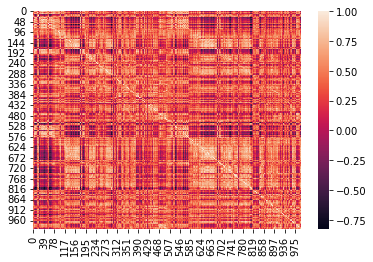

In [16]:
import seaborn as sns

sns.heatmap(
    correlation_matrix1000
    )

In [17]:
from nilearn.datasets import fetch_atlas_schaefer_2018

atlas = fetch_atlas_schaefer_2018(n_rois=1000, resolution_mm=2)

labels = [x.decode() for x in atlas['labels']]

atlas['labels'].shape

/Users/qasem/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


(1000,)

In [18]:
# from nilearn import datasets
from brainspace.utils.parcellation import reduce_by_labels

In [19]:
# # Remove REGIONS
# regions = atlas['labels'].copy()
# masked_regions = [b'7Networks_RH_Cont_Cing_1', b'7Networks_RH_Vis_33']
# masked_labels = [regions.index(r) for r in masked_regions]
# for r in masked_regions:
#     regions.remove(r)


In [20]:
len(labels)

1000

In [28]:
# masked_regions = ['7Networks_RH_Cont_Cing_1', '7Networks_RH_Vis_33']
# masked_regions = [l for l in labels if l not in masked_regions]
# len(masked_regions)

998

In [22]:
timeseries = baseline.values
timeseries.shape

(219, 998)

In [23]:
atlas.keys()

dict_keys(['maps', 'labels', 'description'])

In [24]:
# Remove non-cortex regions
regions = atlas['labels'].copy().tolist()


In [31]:
masked_regions = [b'7Networks_RH_Cont_Cing_1', b'7Networks_RH_Vis_33']
masked_labels = [regions.index(r) for r in masked_regions]

In [32]:
masked_labels

[902, 532]

In [33]:
for r in masked_regions:
    regions.remove(r)

also conn matrix

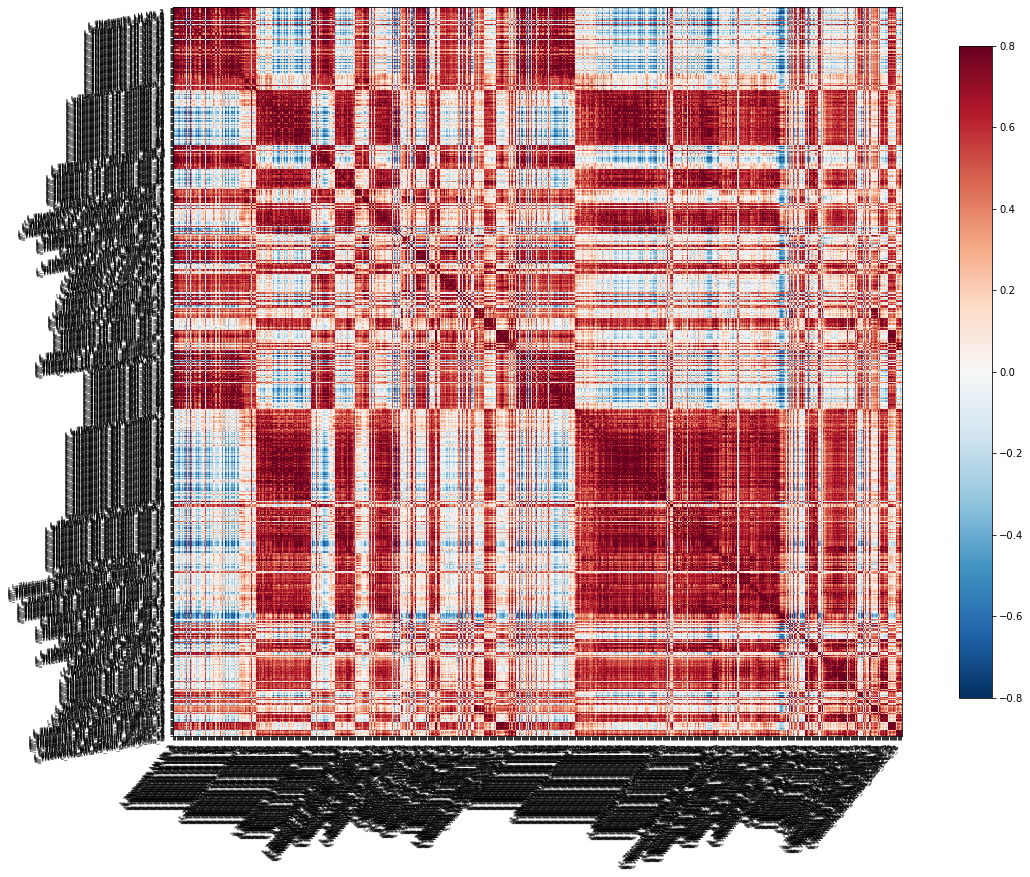

In [34]:
from nilearn import plotting
import numpy as np

# Reduce matrix size, only for visualization purposes
mat_mask = np.where(np.std(correlation_matrix1000, axis=1) > 0.2)[0]
c = correlation_matrix1000[mat_mask][:, mat_mask]

# Create corresponding region names
regions_list = ['%s_%s' % (h, r.decode()) for h in ['L', 'R'] for r in regions]
masked_regions = [regions_list[i] for i in mat_mask]

corr_plot = plotting.plot_matrix(c, figure=(15, 15), labels=masked_regions,
                                 vmax=0.8, vmin=-0.8, reorder=False)


https://github.com/nilearn/nilearn/issues/1633

In [ ]:
#todo plot conn with rs labels!

In [87]:
import nibabel as nib
import numpy as np

surf_labels_lh = nib.freesurfer.read_annot('atlas/Schaefer2018_1000Parcels_7Networks/lh.Schaefer2018_1000Parcels_7Networks_order.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot('atlas/Schaefer2018_1000Parcels_7Networks/rh.Schaefer2018_1000Parcels_7Networks_order.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 500  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])


In [88]:
(surf_labels == 0).sum()

1743

In [89]:
masked_labels += [0]
masked_labels

[902, 532, 0]

In [90]:
# Build Destrieux parcellation and mask

mask = ~np.isin(surf_labels, masked_labels)

In [91]:
surf_labels

array([145, 214, 128, ..., 833, 833, 833], dtype=int32)

In [92]:
len(mask), (mask == False).sum()

(20484, 1773)

In [93]:
from brainspace.utils.parcellation import reduce_by_labels

# extract mean timeseries for each label
seed_ts = reduce_by_labels(timeseries[mask], surf_labels[mask], axis=1, red_op='mean')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 219 but corresponding boolean dimension is 20484

In [94]:
from brainspace.gradient import GradientMaps
Gsub = GradientMaps(n_components=10, random_state=0, alignment="procrustes",
                      approach="dm")
Gsub.fit(correlation_matrix1000, sparsity=0.9)  # shape of Gsub.gradients_[:, 0] is 1000

/Users/qasem/opt/anaconda3/envs/nienv/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(alignment='procrustes', random_state=0)

In [95]:
len(set(surf_labels)), len(set(surf_labels[mask]))

(1001, 998)

In [96]:
from brainspace.utils.parcellation import map_to_labels

grad = map_to_labels(Gsub.gradients_[:, 0], surf_labels, mask=mask, fill=np.nan)

In [97]:
grad2 = map_to_labels(Gsub.gradients_[:, 1], surf_labels, mask=mask, fill=np.nan)

In [98]:
from brainspace.datasets import load_fsa5
surf_lh, surf_rh = load_fsa5()

In [99]:
from brainspace.plotting import plot_hemispheres

plot_hemispheres(surf_lh, surf_rh,
array_name=[surf_labels, grad, grad2], 
filename='subject 43 - baseline gradients',
    size=(1200, 600), color_bar=True, 
    cmap=['tab20', 'viridis_r', 'viridis_r'],
    zoom=1.5, label_text=['Schaefer\n1000', 'First\ngradient', 'Second\ngradient'])


In [ ]:
#todo surfplot